In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [3]:
IMAGE_SIZE = 128
BATCH_SIZE = 128
EPOCHS = 20

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/code/plant_disease_classifier/train/crop_data",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 13159 files belonging to 31 classes.


In [5]:
class_names = dataset.class_names
len(class_names)

31

In [6]:
class_names

['Corn___Common_Rust',
 'Corn___Gray_Leaf_Spot',
 'Corn___Healthy',
 'Corn___Northern_Leaf_Blight',
 'Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Rice___Brown_Spot',
 'Rice___Healthy',
 'Rice___Leaf_Blast',
 'Rice___Neck_Blast',
 'Sugarcane__Healthy',
 'Sugarcane__Mosaic',
 'Sugarcane__RedRot',
 'Sugarcane__Rust',
 'Sugarcane__Yellow',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy',
 'Wheat___Brown_Rust',
 'Wheat___Healthy',
 'Wheat___Yellow_Rust']

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(128, 128, 128, 3)
[18  5 12 19 25 14  2 11  5 17  3 27 25 22 11  6 29 12 12 21  4  5 10 28
  9 29 13 23 15 24 30 12  2 17  3  3 23 27 30 28  2 20 13 29 10 10 20 30
  1  5 12 23 20 27 19  3 15 27 14 27  0 27 28  9 21 22 24 19  5 22 20 19
 14 21 17 19 24 12  9 30  1 16  9  4 20 23 21  5 22 16 13 11 25 28 19 22
 20 22  1  0 17 14 11  5 25  5 11 13 29  4  4  0 18 13 21 25  7 13 24  3
 12 20  0 30 25 25 20  3]


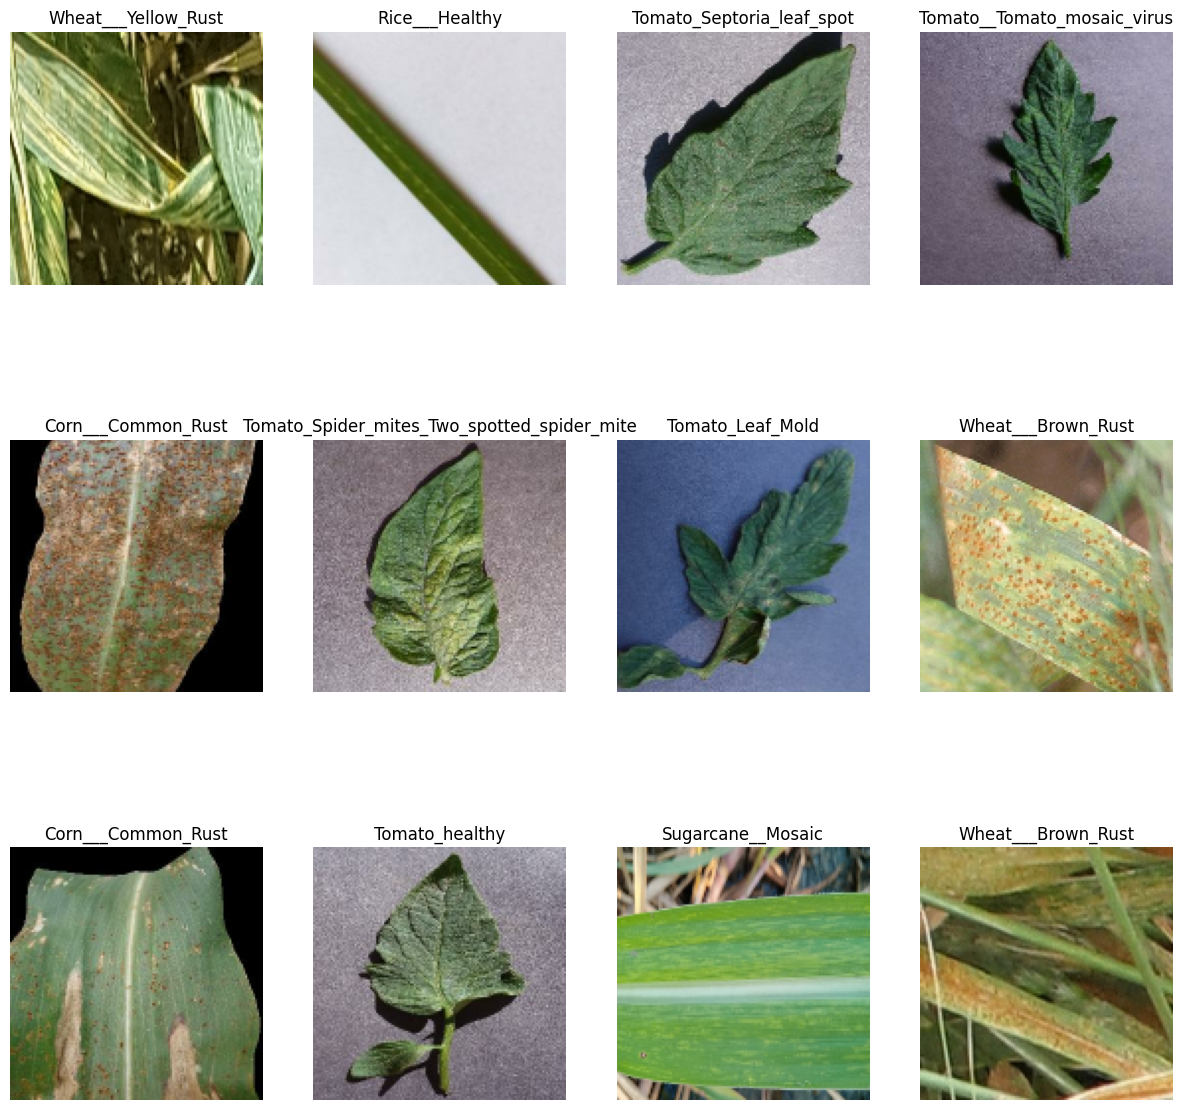

In [8]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("int32"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

**80% ==>training**

**20% ==> 10% validation, 10% test**

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed =12)

    train_size = int(train_split * ds_size)

    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    

    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
len(test_ds)

11

# caching ==> Read the image in first epoch

**and  in next epochs this method will retain the images in the memory for training**

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

**For resizing and Rescaling**

In [13]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(height=IMAGE_SIZE, width=IMAGE_SIZE, interpolation='bilinear'),
    layers.Rescaling(scale=1.0 / 255)
])

# Data augmentation 

**with this method model will become more generalized**

In [14]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip(mode="horizontal_and_vertical", seed=None,),
    layers.RandomRotation(0.2)
])

In [15]:
CHANNELS = 3
Input_shape = (BATCH_SIZE ,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 31

In [16]:
Input_shape

(128, 128, 128, 3)

In [17]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,

    # Convolution layers
    layers.Conv2D(128, (3,3), activation='relu',padding='same', input_shape = Input_shape),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3),padding='same', activation='relu'),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, (3,3),padding='same', activation='relu'),
    layers.Conv2D(16, (3,3), activation='relu'),
    layers.MaxPooling2D((3,2)),
    
    layers.Dropout(0.2),
    # Neural layers

    layers.Flatten(),
    layers.Dense(160, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation='softmax')


])


model.build(input_shape = Input_shape)

C:\Users\saura\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (128, 128, 128, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (128, 128, 128, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (128, 128, 128, 128)   │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (128, 126, 126, 64)    │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (128, 63, 63, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (128, 63, 63, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (128, 61, 61, 32)      │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (128, 30, 30, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (128, 30, 30, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (128, 28, 28, 16)      │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (128, 9, 14, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (128, 9, 14, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (128, 2016)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (128, 160)             │       322,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (128, 160)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (128, 31)              │         4,991 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 474,351 (1.81 MB)

 Trainable params: 474,351 (1.81 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [20]:
training_history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size = BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1245s 15s/step - accuracy: 0.0612 - loss: 3.2700 - val_accuracy: 0.2945 - val_loss: 2.0726
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1208s 15s/step - accuracy: 0.3184 - loss: 2.0858 - val_accuracy: 0.5070 - val_loss: 1.4416
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1251s 15s/step - accuracy: 0.4498 - loss: 1.6248 - val_accuracy: 0.5805 - val_loss: 1.2160
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1225s 15s/step - accuracy: 0.5144 - loss: 1.4218 - val_accuracy: 0.5977 - val_loss: 1.1415
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1173s 14s/step - accuracy: 0.5608 - loss: 1.2623 - val_accuracy: 0.6562 - val_loss: 0.9560
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1142s 14s/step - accuracy: 0.6228 - loss: 1.1139 - val_accuracy: 0.7008 - val_loss: 0.9079
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1145s 14s/step - accuracy: 0.6456 - loss: 1.0166 - val_accuracy: 0.7023 - val_loss: 0.8513
Epoch 8/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1140s 14s/step - accuracy: 0.6642 - loss: 0.9707 - val_accu

In [21]:
scores = model.evaluate(test_ds)

11/11 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.8020 - loss: 0.5654


In [22]:
training_history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [23]:
acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']

loss = training_history.history['loss']
val_loss = training_history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Error')

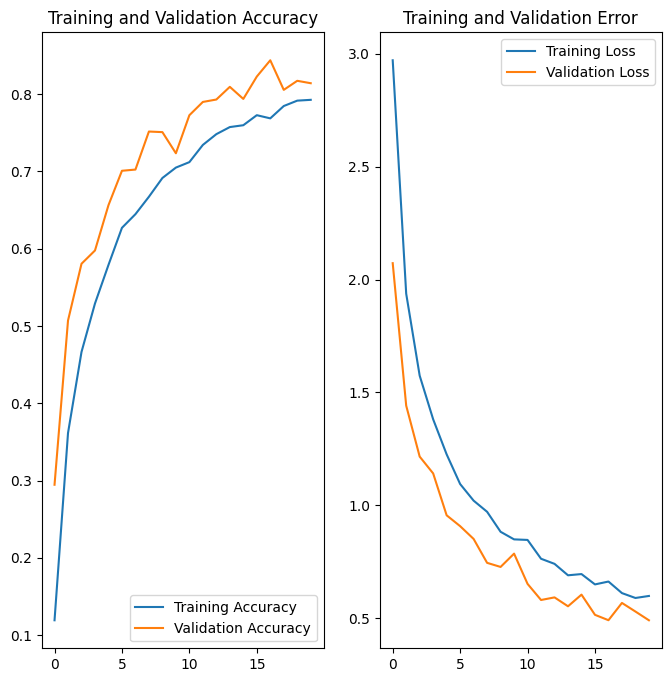

In [24]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')



plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Error')



FIrst image to predict
first image's actual label: Tomato_Bacterial_spot
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 684ms/step
predicted label: Tomato_Bacterial_spot


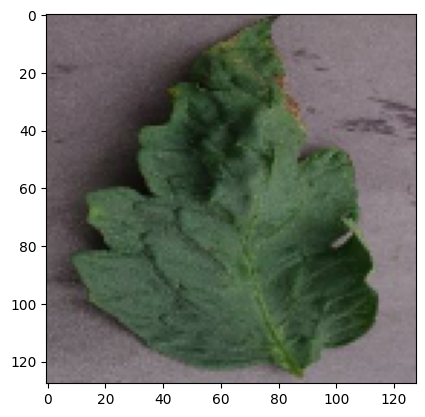

In [25]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype("int16")
    first_label = labels_batch[0].numpy()

    print("FIrst image to predict")
    plt.imshow(first_image)
    print("first image's actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)

    print("predicted label:",class_names[np.argmax(batch_prediction[0])])



In [26]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


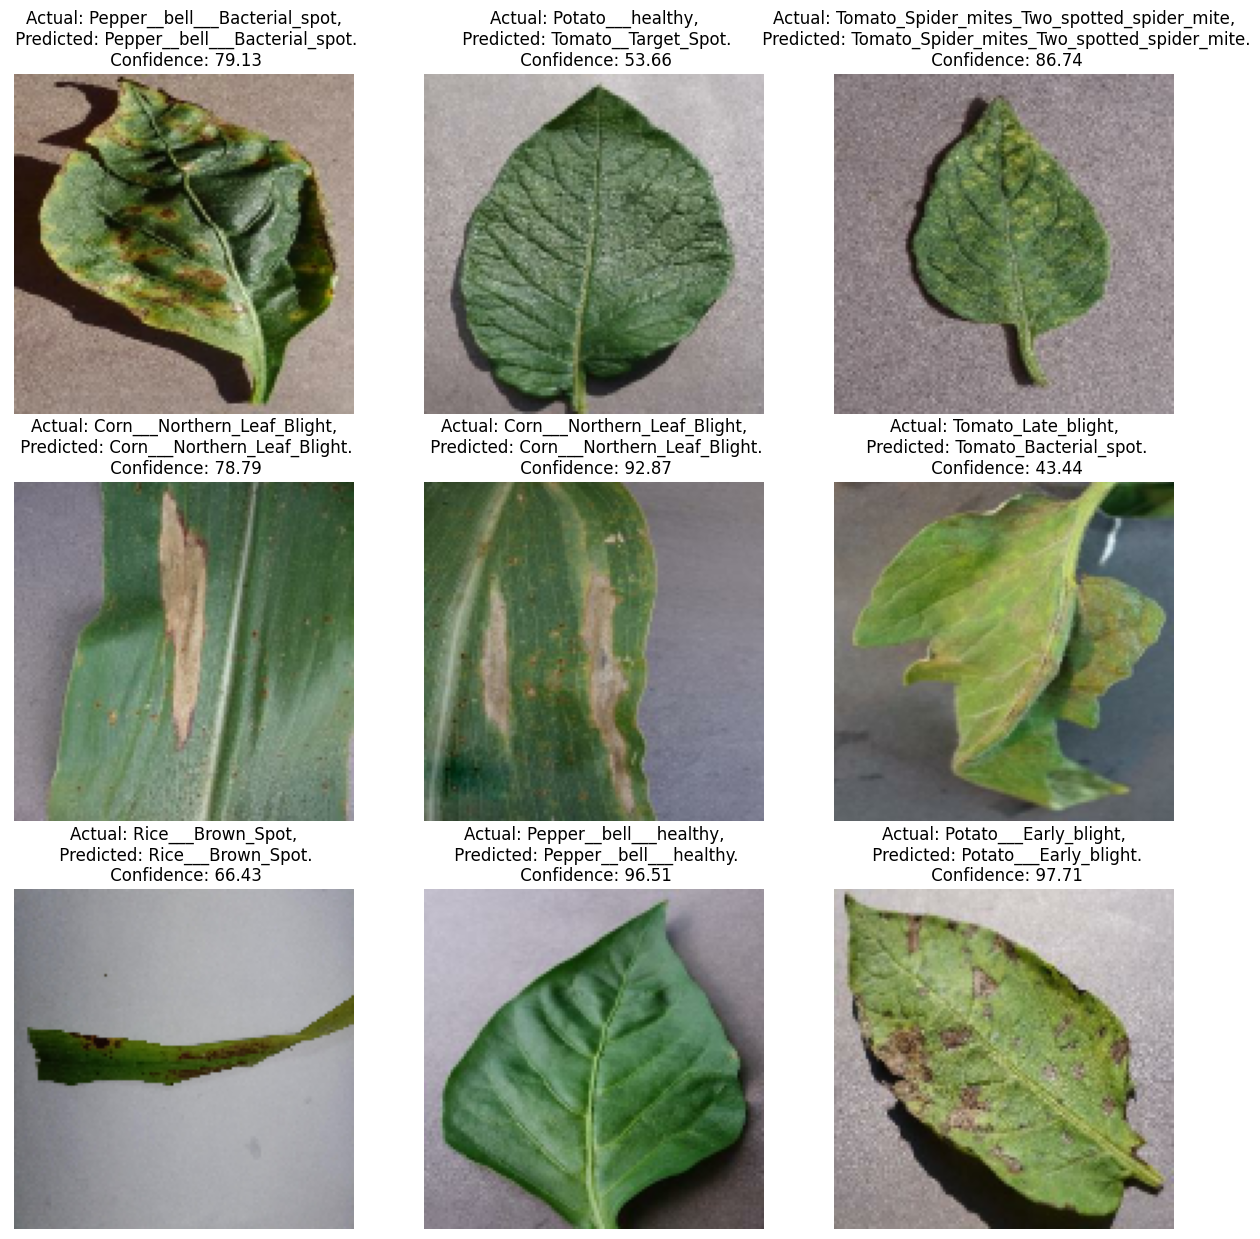

In [27]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('int16'))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}")

        plt.axis("off")

In [32]:
model_version = 3
model.save("C:/code/plant_disease_classifier/train/disease_model.keras")


In [33]:
model.save("C:/code/plant_disease_classifier/train/disease_model.h5")

TypeError: cannot pickle 'module' object

In [35]:
model.save("C:/code/plant_disease_classifier/train/models.h5")

TypeError: cannot pickle 'module' object

In [36]:
training_history.history

{'accuracy': [0.11918632686138153,
  0.36147454380989075,
  0.46633559465408325,
  0.529080331325531,
  0.5789322853088379,
  0.6269697546958923,
  0.6446375846862793,
  0.6671760082244873,
  0.6914334893226624,
  0.704899251461029,
  0.7119663953781128,
  0.7342182993888855,
  0.7481616139411926,
  0.7573297619819641,
  0.7597172856330872,
  0.7727055549621582,
  0.7685989737510681,
  0.7845478057861328,
  0.7915194630622864,
  0.7925699353218079],
 'loss': [2.9712092876434326,
  1.937447428703308,
  1.574375033378601,
  1.3811030387878418,
  1.2258683443069458,
  1.0945403575897217,
  1.0209286212921143,
  0.9715591073036194,
  0.883032500743866,
  0.8494265675544739,
  0.8469782471656799,
  0.7636287212371826,
  0.7410358786582947,
  0.6903497576713562,
  0.6957656741142273,
  0.6499817967414856,
  0.6626768708229065,
  0.6115240454673767,
  0.5898855924606323,
  0.5988199710845947],
 'val_accuracy': [0.2945312559604645,
  0.507031261920929,
  0.5804687738418579,
  0.59765625,
  0.6

In [37]:
#Recording History in json
import json
with open('C:/code/plant_disease_classifier/train/training_hist.json','w') as f:
  json.dump(training_history.history,f)